In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
from DFL_util import dataset_model_set, create_graph_object
import os, sys
from matplotlib.font_manager import FontProperties
import textwrap
import pickle as pk

In [ ]:
def normalize(group, topo):
    min_val = group[topo].min()
    max_val = group[topo].max()
    # print(f"ATTACT METRICS: {group['ATTACT METRICS'].iloc[0]}, Min: {min_val}, Max: {max_val}")
    group['Normalized_value'] = (group[topo] - min_val) / (max_val - min_val)
    return group

In [ ]:
def extract_data_from_directory(directory_path, feature_filename):
    file_path = os.path.join(directory_path, f'{feature_filename}.csv')
    # files = sorted(glob.glob(file_pattern))
    
    # if not files:
    #   raise FileNotFoundError(f"No files found in the directory {directory_path} matching the pattern {files}")
    
    df = pd.read_csv(file_path,index_col=0) # here since we only extract from Round_9, so the files is single.
    
    return df

In [ ]:
# path = 'j:\\TIA\\TIA\\saved_metrics\\FMnist_mlp_star_1_0.1_42_10_10\\_entropy_metric.csv'
# df = pd.read_csv(path,index_col=0)
# df

In [ ]:
def _data_prepare(data, graph):
    data = np.array(data.iloc[0:, 0:].values, dtype=float)
    num_nodes = data.shape[0]
    
    # Check if the data matrix is symmetric
    is_symmetric = np.allclose(data, data.T)
    
    # Prepare features and labels
    X = []
    y = []
    
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:  # Skip diagonal (self-connection)
                # If the matrix is symmetric, only process one side of the diagonal
                if is_symmetric and i < j:
                    # Feature vector for node pair (i, j)
                    feature_vector = [data[i, j]]
                    X.append(feature_vector)
                    
                    # Label: 1 if there is an edge between nodes i and j, 0 otherwise
                    if graph.has_edge(i, j):
                        y.append(1)  # Direct link in the graph
                    else:
                        y.append(0)  # No direct link in the graph
    
                # If the matrix is asymmetric, process both sides
                elif not is_symmetric:
                    # Feature vector for node pair (i, j)
                    feature_vector = [data[i, j]]
                    X.append(feature_vector)
    
                    # Label: 1 if there is an edge between nodes i and j, 0 otherwise
                    if graph.has_edge(i, j):
                        y.append(1)  # Direct link in the graph
                    else:
                        y.append(0)  # No direct link in the graph
    
    # Convert X and y to NumPy arrays
    X = np.array(X).flatten()
    y = np.array(y)
    
    return X , y

In [ ]:
# DATASET = ["Mnist", "Cifar10no"]
# TOPOLOGY = ["star", "ring", "ER_0.5"]
# MODEL = ["mlp", "mobile"]
# MAX_EPOCHS = [10]
# METRICS = ["Average_Loss", "Cosine_Similarity", "Euclidean_Distance", "Average_Entropy"]
# NUM = 10 
# ROUND = 9

# IID = 1    
# ALPHA = 0.1 
# SEED = 42

In [ ]:
DATASET = ["Cifar10no", "FMnist", "Mnist"]
TOPOLOGY = ["star", "ring", "ER_0.3",  "ER_0.5", "ER_0.7"]
MODEL = ["mlp", "mobile"]
MAX_EPOCHS = [10]
METRICS = ['_cosine_metric', '_curvature_divergence', '_entropy_metric', '_euclidean_metric', '_jacobian_metric', '_loss_metric']
# NUM = 10 
# ROUND = 9
NUM_CLIENTS = [10, 20,30,12,22,50,79,87, 15, 161, 37, 11, 25, 35, 26, 39, 16, 28, 17, 14,  40,  27, 24, 65, 54]
IID = 1    
ALPHA = 0.1 
SEED = 42

In [ ]:
dataset = DATASET[0]
model_name = MODEL[1]
topo = TOPOLOGY[1]
num = 20
cur_dir = os.getcwd()
topology_path = f"{cur_dir}/topologies/"

fig, axs = plt.subplots(5, 3, layout='constrained', figsize=(12, 12), sharey=True, sharex=True)

for j, dataset in enumerate(DATASET):
    if dataset == 'Cifar10no':
        model_name = MODEL[1]
    else:
        model_name = MODEL[0]
    
    # for num in NUM_CLIENTS:
    for i, topo in enumerate(TOPOLOGY):  
        case_dict = {} 
        toponame_file = f"{topology_path}/{num}_{topo}.pk"
        if os.path.exists(toponame_file):  
            with open(toponame_file, "rb") as f:
                G = pk.load(f)
        else:
            continue

        for metric in METRICS:
            if metric == "_loss_metric":
                metric_n = "Relative Loss"
            elif metric == "_cosine_metric":
                metric_n = "Cosine Similarity"
            elif metric == "_entropy_metric":
                metric_n = "Relative Entropy"
            elif metric == "_euclidean_metric":
                metric_n = "Euclidean Similarity"
            elif metric == "_curvature_divergence":
                metric_n = "Curvature Divergence"
            elif metric == "_jacobian_metric":
                metric_n = "Relative Sensitivity"
                    
            case_dict[metric_n]=[]
                            
            # G = create_graph_object(NUM, topo)         
            
            for max_epoch in MAX_EPOCHS:
                file_name = dataset + "_" + model_name + "_" + topo + "_" + str(IID) + "_" + str(ALPHA) + "_" + str(SEED) + "_" + str(max_epoch)+ "_" + str(num)
                file_path = os.path.join(cur_dir, f"saved_metrics\\{file_name}\\")
                print(file_path)
                FL_data = extract_data_from_directory(file_path, metric)
                
                X, y = _data_prepare(FL_data, G)
                
                edge_group = X[y == 1]
                non_edge_group = X[y == 0]
                
                
                
                case_dict[metric_n].append(edge_group)
                case_dict[metric_n].append(non_edge_group)
                
        data  =  case_dict     
        plot_data = {
                    'ATTACT METRICS': ['Relative Loss'] * (len(data['Relative Loss'][0]) + len(data['Relative Loss'][1])) +
                                    ['Relative Entropy'] * (len(data['Relative Entropy'][0]) + len(data['Relative Entropy'][1]))+
                                    ['Relative Sensitivity'] * (len(data['Relative Sensitivity'][0]) + len(data['Relative Sensitivity'][1])) +
                                ['Cosine Similarity'] * (len(data['Cosine Similarity'][0]) + len(data['Cosine Similarity'][1])) +                                                            
                                ['Euclidean Similarity'] * (len(data['Euclidean Similarity'][0]) + len(data['Euclidean Similarity'][1])) +
                                ['Curvature Divergence'] * (len(data['Curvature Divergence'][0]) + len(data['Curvature Divergence'][1])),
                                
                    
                    f'{topo}': np.concatenate([data['Relative Loss'][0], data['Relative Loss'][1],
                                            data['Relative Entropy'][0], data['Relative Entropy'][1],
                                            data['Relative Sensitivity'][0], data['Relative Sensitivity'][1],
                                            data['Cosine Similarity'][0], data['Cosine Similarity'][1],                                                                                       
                                            data['Euclidean Similarity'][0], data['Euclidean Similarity'][1]],
                                              data['Curvature Divergence'][0], data['Curvature Divergence'][1]),
                    
                    'Connection Type': ['Edge'] * len(data['Relative Loss'][0]) + ['Non-Edge'] * len(data['Relative Loss'][1]) +
                                    ['Edge'] * len(data['Relative Entropy'][0]) + ['Non-Edge'] * len(data['Relative Entropy'][1]) +
                                    ['Edge'] * len(data['Relative Sensitivity'][0]) + ['Non-Edge'] * len(data['Relative Sensitivity'][1]) +
                                    ['Edge'] * len(data['Cosine Similarity'][0]) + ['Non-Edge'] * len(data['Cosine Similarity'][1]) +                                                                      
                                    ['Edge'] * len(data['Euclidean Similarity'][0]) + ['Non-Edge'] * len(data['Euclidean Similarity'][1]) +
                                    ['Edge'] * len(data['Curvature Divergence'][0]) + ['Non-Edge'] * len(data['Curvature Divergence'][1])
                }
        df = pd.DataFrame(plot_data)
        nor_df = df.groupby('ATTACT METRICS', group_keys=False).apply(lambda g: normalize(g, topo=topo))
        nor_df['Normalized_value'] = nor_df['Normalized_value'].clip(0, 1)

        palette = ['#F87060','#153B50' ] 
        sns.violinplot(data=nor_df, x='ATTACT METRICS', y='Normalized_value', ax=axs[i][j], hue='Connection Type', palette=palette, split=True, inner='quartile')
        wrapped_labels = [textwrap.fill(label.upper(), 10) for label in df['ATTACT METRICS'].unique()]
        axs[i][j].set_xticks(ticks=range(len(wrapped_labels)), labels=wrapped_labels, rotation=0)
        
        if j==4:            
            axs[i][j].set_xlabel('ATTACK METRICS', fontsize=12)  
        # else:
        #     axs[i][j].set_xticks(None)
        #     axs[i][j].set_xlabel(None)  
        
        if j==0:
            axs[i][j].set_ylabel(f'{topo.upper()}', fontsize=12)
        else:
            axs[i][j].set_ylabel(None)
        
        dataset_name = dataset
        if i==0:
            if dataset_name=='Cifar10no':                
                dataset_name='Cifar10'
            axs[i][j].set_title(f'{dataset_name.upper()}', fontsize=12)
        else:
            axs[i][j].set_title(None)
        
        axs[i][j].legend().remove()
        
        df = None
                
handles, labels = axs[0][0].get_legend_handles_labels()
labels = [x.upper() for x in labels]
fig.legend(handles, labels,loc='upper center',bbox_to_anchor=(0.5, 1.04), ncol=2, fontsize=12)

        # 
        # plt.xticks(ticks=range(len(wrapped_labels)), labels=wrapped_labels, rotation=0)


        # plt.xlabel('ATTACK METRICS', fontsize=16)  
        # plt.ylabel('NORMALIZED VLAUE', fontsize=16)
        # # plt.ylim(0, 1)
# plt.tight_layout(pad=2.0, w_pad=2.5, h_pad=1.0)
# plt.savefig('all_metrics_distribution.pdf', format='pdf', bbox_inches='tight')


In [63]:
dataset = DATASET[1]
model_name = MODEL[0]
topo = TOPOLOGY[0]
num = 30
IID = 1    
ALPHA = 0.1 
SEED = 42
MAX_EPOCHS = [3]

In [64]:
cur_dir = os.getcwd()
topology_path = f"{cur_dir}/topologies/"

In [65]:
case_dict = {} 
toponame_file = f"{topology_path}/{num}_{topo}.pk"
if os.path.exists(toponame_file):  
    with open(toponame_file, "rb") as f:
        G = pk.load(f)

In [66]:
for metric in METRICS:
    if metric == "_loss_metric":
        metric_n = "Relative Loss"
    elif metric == "_cosine_metric":
        metric_n = "Cosine Similarity"
    elif metric == "_entropy_metric":
        metric_n = "Relative Entropy"
    elif metric == "_euclidean_metric":
        metric_n = "Euclidean Similarity"
    elif metric == "_curvature_divergence":
        metric_n = "Curvature Divergence"
    elif metric == "_jacobian_metric":
        metric_n = "Relative Sensitivity"
            
    case_dict[metric_n]=[]
                    
    # G = create_graph_object(NUM, topo)         
    
    for max_epoch in MAX_EPOCHS:
        file_name = dataset + "_" + model_name + "_" + topo + "_" + str(IID) + "_" + str(ALPHA) + "_" + str(SEED) + "_" + str(max_epoch)+ "_" + str(num)
        file_path = os.path.join(cur_dir, f"saved_metrics\\{file_name}\\")
        print(file_path)
        FL_data = extract_data_from_directory(file_path, metric)
        
        X, y = _data_prepare(FL_data, G)
        
        edge_group = X[y == 1]
        non_edge_group = X[y == 0]
        
        
        
        case_dict[metric_n].append(edge_group)
        case_dict[metric_n].append(non_edge_group)

j:\TIA\TIA\saved_metrics\FMnist_mlp_star_1_0.1_42_3_30\
j:\TIA\TIA\saved_metrics\FMnist_mlp_star_1_0.1_42_3_30\
j:\TIA\TIA\saved_metrics\FMnist_mlp_star_1_0.1_42_3_30\
j:\TIA\TIA\saved_metrics\FMnist_mlp_star_1_0.1_42_3_30\
j:\TIA\TIA\saved_metrics\FMnist_mlp_star_1_0.1_42_3_30\
j:\TIA\TIA\saved_metrics\FMnist_mlp_star_1_0.1_42_3_30\


In [73]:
data  =  case_dict 

In [79]:
plot_data = {
            'ATTACT METRICS': ['Relative Loss'] * (len(data['Relative Loss'][0]) + len(data['Relative Loss'][1])) +
                            ['Relative Entropy'] * (len(data['Relative Entropy'][0]) + len(data['Relative Entropy'][1]))+
                            ['Relative Sensitivity'] * (len(data['Relative Sensitivity'][0]) + len(data['Relative Sensitivity'][1])) +
                        ['Cosine Similarity'] * (len(data['Cosine Similarity'][0]) + len(data['Cosine Similarity'][1])) +                                                            
                        ['Euclidean Similarity'] * (len(data['Euclidean Similarity'][0]) + len(data['Euclidean Similarity'][1])) +
                        ['Curvature Divergence'] * (len(data['Curvature Divergence'][0]) + len(data['Curvature Divergence'][1])),
                        
            
            f'{topo}': np.concatenate([data['Relative Loss'][0], data['Relative Loss'][1],
                                    data['Relative Entropy'][0], data['Relative Entropy'][1],
                                    data['Relative Sensitivity'][0], data['Relative Sensitivity'][1],
                                    data['Cosine Similarity'][0], data['Cosine Similarity'][1],                                                                                       
                                    data['Euclidean Similarity'][0], data['Euclidean Similarity'][1],
                                        data['Curvature Divergence'][0], data['Curvature Divergence'][1]]),
            
            'Connection Type': ['Edge'] * len(data['Relative Loss'][0]) + ['Non-Edge'] * len(data['Relative Loss'][1]) +
                            ['Edge'] * len(data['Relative Entropy'][0]) + ['Non-Edge'] * len(data['Relative Entropy'][1]) +
                            ['Edge'] * len(data['Relative Sensitivity'][0]) + ['Non-Edge'] * len(data['Relative Sensitivity'][1]) +
                            ['Edge'] * len(data['Cosine Similarity'][0]) + ['Non-Edge'] * len(data['Cosine Similarity'][1]) +                                                                      
                            ['Edge'] * len(data['Euclidean Similarity'][0]) + ['Non-Edge'] * len(data['Euclidean Similarity'][1]) +
                            ['Edge'] * len(data['Curvature Divergence'][0]) + ['Non-Edge'] * len(data['Curvature Divergence'][1])
                }

In [80]:
df = pd.DataFrame(plot_data)
df

,ATTACT METRICS,star,Connection Type
0,Relative Loss,0.000074,Edge
1,Relative Loss,0.000122,Edge
2,Relative Loss,0.000094,Edge
3,Relative Loss,0.000117,Edge
4,Relative Loss,0.000096,Edge
...,...,...,...
3910,Curvature Divergence,0.907869,Non-Edge
3911,Curvature Divergence,0.973592,Non-Edge
3912,Curvature Divergence,0.939046,Non-Edge
3913,Curvature Divergence,0.929342,Non-Edge


In [81]:
# Apply normalization by group
nor_df = df.groupby('ATTACT METRICS', group_keys=False).apply(lambda g: normalize(g, topo=topo))
nor_df['Normalized_value'] = nor_df['Normalized_value'].clip(0, 1)

C:\Users\luke-\AppData\Local\Temp\ipykernel_35304\521494894.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nor_df = df.groupby('ATTACT METRICS', group_keys=False).apply(lambda g: normalize(g, topo=topo))


In [82]:
nor_df['Connection Type']= nor_df['Connection Type'].apply(str.upper)
nor_df['ATTACT METRICS']= nor_df['ATTACT METRICS'].apply(str.upper)

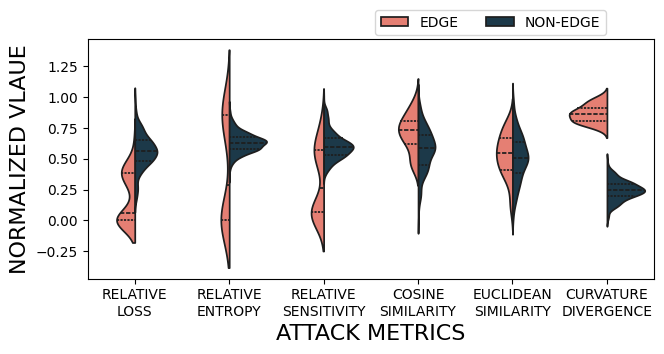

In [84]:
plt.figure(figsize=(7,4))
palette = ['#F87060','#153B50' ] 
sns.violinplot(data=nor_df, x='ATTACT METRICS', y='Normalized_value', hue='Connection Type', palette=palette, split=True, inner='quartile')

plt.legend(loc='upper left', bbox_to_anchor=(0.495, 1.15), ncol=2)

wrapped_labels = [textwrap.fill(label.upper(), 11) for label in df['ATTACT METRICS'].unique()]
plt.xticks(ticks=range(len(wrapped_labels)), labels=wrapped_labels, rotation=0)


plt.xlabel('ATTACK METRICS', fontsize=16)  
plt.ylabel('NORMALIZED VLAUE', fontsize=16)
# plt.ylim(0, 1)
plt.tight_layout(pad=2.0, w_pad=2.5, h_pad=1.0)
plt.savefig('metrics_distribution.pdf')